<a href="https://colab.research.google.com/github/Mohamed-Mohamed-Ibrahim/Face-Recognition/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Define the transformation
transform = transforms.ToTensor()

# Load the entire training dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Initialize empty lists to collect image data and labels
X = []
y = []

# Loop through the entire dataset
for image, label in train_dataset:
    if len(X) == 100:
        break
    image_numpy = image.numpy().squeeze()  # shape: (28, 28)
    X.append(image_numpy)
    y.append(label)

# Convert to NumPy arrays
X = np.array(X)  # shape: (60000, 28, 28)
y = np.array(y)  # shape: (60000,)
X = X.reshape(len(X), -1) 
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 3.83MB/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4.42M/4.42M [00:00<00:00, 58.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

X shape: (100, 784)
y shape: (100,)


In [131]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)  # Reduce to 50 components (you can adjust this)
X = pca.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"PCA-reduced shape: {X_pca.shape}")

Original shape: (100, 784)
PCA-reduced shape: (100, 40)


In [10]:
from sklearn.model_selection import train_test_split

# Let's say you already have:
# X_pca: shape (60000, 50)
# y:     shape (60000,)

# Split into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")


Train shape: (240, 2)
Test shape:  (60, 2)


In [11]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import multivariate_normal


class GMM(BaseEstimator, RegressorMixin):
    def __init__(self, n_components=1, tol=0.001, reg_covar=1e-06, max_iter=100, verbose=False, n_init=10):
        self.n_components = n_components
        self.tol = tol
        self.reg_covar = reg_covar
        self.max_iter = max_iter
        self.verbose = verbose
        self.n_init = n_init
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.cluster_meanings = np.zeros(n_components)

    def fit(self, X):
        best_m = None
        best_c = None
        best_w = None
        best_log_likelihood = -np.inf

        for _ in range(self.n_init):
            self.__fit(X)
            ll = self.score(X)
            if ll > best_log_likelihood:
                best_log_likelihood = ll
                best_m = self.means_
                best_c = self.covariances_
                best_w = self.weights_
            self.means_ = None
            self.covariances_ = None
            self.weights_ = None
        self.means_ = best_m
        self.covariances_ = best_c
        self.weights_ = best_w


    def __fit(self, X):

        n_samples, n_features = X.shape
        self.means_ = np.random.rand(self.n_components, n_features)*20 - 10
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))
        for i in range(self.n_components):
            self.covariances_[i] = np.eye(n_features)
        self.weights_ = (1/self.n_components) + np.zeros(self.n_components)
        log_likelihood_old = -np.inf

        r = np.zeros((self.n_components, n_samples))

        for _ in range(self.max_iter):

            if self.verbose and self.max_iter % 50 == 0:
                print(f"Iteration: {_} -> Means {self.means_} -> Var {self.covariances_} -> Weights {self.weights_}")
            
            # E-step
            # Assign r using posterior probability
            for i in range(self.n_components):
                r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

            # Normalization
            for i in range(n_samples):
                r[:, i] = r[:, i] / np.sum(r[:, i])

            old_w = self.weights_.copy()
            old_m = self.means_.copy()
            old_c = self.covariances_.copy()

            # M-step
            for i in range(self.n_components):
                denom = np.sum(r[i, :])
                if denom == 0:
                    continue
                self.weights_[i] = np.sum(r[i, :]) / n_samples

                # for j in range(n_features):
                #     self.means_[i][j] = np.sum(r[i, :] * X[:, j]) / np.sum(r[i, :])
                self.means_[i] = (r[i, :, np.newaxis] * X).sum(axis=0) / np.sum(r[i, :])
                    # for k in range(n_features):
                    #     self.covariances_[i][j, k] = np.sum(r[i, :] * (X[:, j] - self.means_[i][j]) * (X[:, k] - self.means_[i][k])) / np.sum(r[i, :])

                diff = X - self.means_[i]
                self.covariances_[i] = (r[i, :, np.newaxis, np.newaxis] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / np.sum(r[i, :])

                # Regularize covariance
                self.covariances_[i] += self.reg_covar * np.eye(n_features)

            if np.all(np.abs(old_w - self.weights_) < self.tol) and np.all(np.abs(old_m - self.means_) < self.tol) and np.all(np.abs(old_c - self.covariances_) < self.tol):
                break
            # log_likelihood_new = self.score(X)
            # if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
            #     break
            # log_likelihood_old = log_likelihood_new

    def predict(self, X):
        n_samples = len(X)

        r = np.zeros((self.n_components, n_samples))

        for i in range(self.n_components):
            r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])

        return np.argmax(r, axis=0)

    def score(self, X):
        ll = []
        for d in X:
            tot = 0
            for k in range(self.n_components):
                tot += self.weights_[k] * multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])
            ll.append(np.log(tot))
        return np.sum(ll)

    def clusters_meaning(self, X, y):
        pred = self.predict(X)
        n_pred_clusters = self.n_components
        n_classes = len(np.unique(y))
    
        cluster_map = np.zeros((n_pred_clusters, n_classes), dtype=int)
    
        for i in range(len(X)):
            cluster_map[pred[i], y[i]] += 1
    
        self.cluster_meanings = np.zeros(n_pred_clusters, dtype=int)
        for i, row in enumerate(cluster_map):
            self.cluster_meanings[i] = np.argmax(row)

        

# Testing

/tmp/ipykernel_31/1169018517.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')


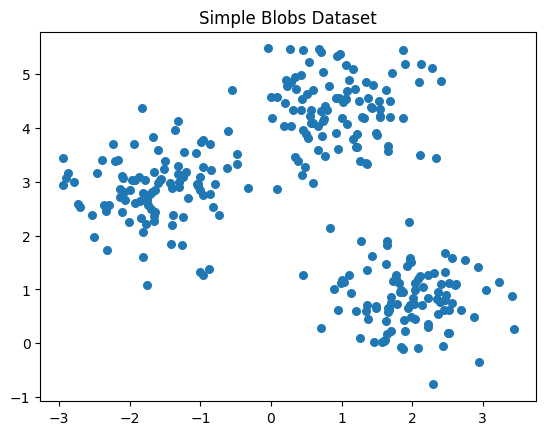

In [9]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate synthetic data
X, y = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=30, cmap='viridis')
plt.title("Simple Blobs Dataset")
plt.show()


# Resourses

- https://www.geeksforgeeks.org/how-to-load-fashion-mnist-dataset-using-pytorch/
- https://youtu.be/wT2yLNUfyoM
- https://scikitlearn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
- https://github.com/scikit-learn/scikit-learn/blob/98ed9dc73/sklearn/mixture/_gaussian_mixture.py#L509

# Evaluation

In [5]:
gmm = GMM(n_components=10, tol=1e-6, max_iter=100)
gmm.fit(X_train)
print(gmm.means_)
print(gmm.covariances_)
print(gmm.weights_)
print(gmm.predict(X_test))

/tmp/ipykernel_31/3110779330.py:65: RuntimeWarning: invalid value encountered in divide
  r[:, i] = r[:, i] / np.sum(r[:, i])
/tmp/ipykernel_31/3110779330.py:90: RuntimeWarning: invalid value encountered in less
  if np.all(np.abs(old_w - self.weights_) < self.tol) and np.all(np.abs(old_m - self.means_) < self.tol) and np.all(np.abs(old_c - self.covariances_) < self.tol):


ValueError: array must not contain infs or NaNs

In [144]:
from sklearn.model_selection import GridSearchCV

gmmfm = GMM(tol=1e-6, max_iter=1000)

parameters = {
    'n_components': [20, 40,  60],
}

diffK = GridSearchCV(gmmfm, parameters)

diffK.fit(X)

/tmp/ipykernel_31/3110779330.py:65: RuntimeWarning: invalid value encountered in divide
  r[:, i] = r[:, i] / np.sum(r[:, i])
/tmp/ipykernel_31/3110779330.py:90: RuntimeWarning: invalid value encountered in less
  if np.all(np.abs(old_w - self.weights_) < self.tol) and np.all(np.abs(old_m - self.means_) < self.tol) and np.all(np.abs(old_c - self.covariances_) < self.tol):


ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/tmp/ipykernel_31/3110779330.py", line 26, in fit
    self.__fit(X)
  File "/tmp/ipykernel_31/3110779330.py", line 61, in __fit
    r[i, :] = self.weights_[i] * multivariate_normal.pdf(X, self.means_[i], self.covariances_[i])
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/stats/_multivariate.py", line 588, in pdf
    params = self._process_parameters(mean, cov, allow_singular)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/stats/_multivariate.py", line 425, in _process_parameters
    psd = _PSD(cov, allow_singular=allow_singular)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/stats/_multivariate.py", line 168, in __init__
    s, u = scipy.linalg.eigh(M, lower=lower, check_finite=check_finite)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/linalg/_decomp.py", line 458, in eigh
    a1 = _asarray_validated(a, check_finite=check_finite)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py", line 537, in _asarray_validated
    a = toarray(a)
        ^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py", line 630, in asarray_chkfinite
    raise ValueError(
ValueError: array must not contain infs or NaNs


In [ ]:

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Train Decision Tree
desicion_tree = DecisionTreeCustom(min_samples_split=5, max_depth=100, purity_ratio=0.01)
desicion_tree.fit(X_train, y_train)

# Make predictions
y_pred = desicion_tree.predict(X_test)

# Evaluate accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print()
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
print()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Fine Tuning 

In [13]:
print(gmm.predict(X_train))
print(y_train)
gmm.clusters_meaning(X_train, y_train)
print(gmm.cluster_meanings[gmm.predict(X_train)])
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
accuracy_score(gmm.cluster_meanings[gmm.predict(X_train)], y_train)

[1 2 0 2 2 0 1 0 2 0 0 1 2 0 1 2 1 1 2 0 2 0 2 0 1 1 0 2 1 2 1 1 0 0 1 2 1
 2 1 1 0 0 2 0 2 2 2 0 2 0 2 1 0 0 1 0 1 0 1 2 0 0 2 0 0 2 0 1 0 1 0 2 2 1
 2 2 2 1 1 2 2 2 0 1 0 0 1 2 1 0 0 0 2 0 1 2 2 1 1 1 1 1 2 0 2 2 2 2 2 2 0
 1 0 2 0 0 1 1 1 1 0 1 2 0 2 0 1 1 2 1 2 0 1 0 2 0 1 1 0 2 0 0 2 1 0 0 0 1
 2 2 2 0 2 2 0 1 1 1 1 2 1 1 2 2 1 0 1 1 1 2 0 0 0 2 2 2 2 2 0 1 2 0 0 2 0
 1 1 1 1 2 1 0 2 0 2 0 0 2 0 0 2 1 1 2 2 1 2 1 0 0 1 1 0 1 1 2 1 1 0 0 2 1
 2 1 1 0 1 1 0 1 2 0 1 2 1 2 0 2 0 0]
[0 1 2 1 1 2 0 2 1 2 2 0 1 2 0 1 0 0 1 2 1 2 1 2 0 0 2 1 0 1 0 0 2 2 0 1 0
 1 0 0 2 2 1 2 1 1 1 2 1 2 1 0 2 2 0 2 0 2 0 1 2 2 1 2 2 1 2 0 2 0 2 1 1 0
 1 1 1 0 0 1 1 1 2 0 2 2 0 1 0 2 2 2 1 2 0 1 1 0 0 0 0 0 1 2 1 1 1 1 1 1 2
 0 2 1 2 2 0 0 0 0 2 0 1 2 1 2 2 0 1 0 1 2 0 2 1 2 0 0 2 1 2 2 1 0 2 2 2 0
 1 1 1 2 1 1 2 0 0 0 0 1 0 0 1 1 0 2 0 0 0 1 2 2 2 1 1 1 1 1 2 0 1 2 2 1 2
 0 0 0 0 1 0 2 1 2 1 2 2 1 2 2 1 0 0 1 1 0 1 0 2 2 0 0 2 0 0 1 0 0 2 2 1 0
 1 0 0 2 0 0 2 0 1 2 0 1 0 1 2 1 2 2]
[0 1 2 1 1 2 0 2 1 2 2 0

0.9958333333333333

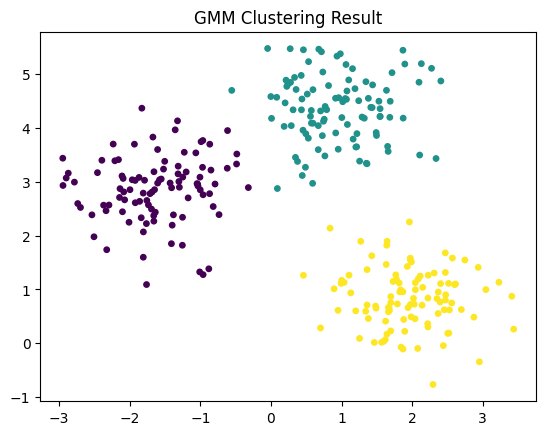

In [12]:
gmm = GMM(n_components=3, tol=1e-9, max_iter=100)
gmm.fit(X)
labels = gmm.predict(X)



plt.scatter(X[:, 0], X[:, 1], c=labels, s=15, cmap='viridis')
plt.title("GMM Clustering Result")
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV

gmmfm = GMM()

parameters = {
    'n_components': [1, 2, 3, 4],
    'tol': [1e-3, 1e-4],
    'reg_covar': [1e-6, 1e-5],
    'max_iter': [100],
    'n_init': [1, 5]
}

clf = GridSearchCV(gmmfm, parameters)

clf.fit(X)

GridSearchCV(estimator=GMM(),
             param_grid={'max_iter': [100], 'n_components': [1, 2, 3, 4],
                         'n_init': [1, 5], 'reg_covar': [1e-06, 1e-05],
                         'tol': [0.001, 0.0001]})

In [23]:
sorted(clf.best_params_.items())

[('max_iter', 100),
 ('n_components', 4),
 ('n_init', 5),
 ('reg_covar', 1e-06),
 ('tol', 0.0001)]

In [28]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Make predictions
y_pred = clf.predict(X)

# Evaluate accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

NameError: name 'y_test' is not defined